<a href="https://colab.research.google.com/github/eleshuk/machine_learning/blob/main/20250617_assignment4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we present a total pipeline for the MNIST data set, using a custom convolutional neural network `simple_cnn`.

We discuss how to save and load the trained model.

In [1]:
!pip install torchvision

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 73.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 97.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

### Change device: run training on GPU

Training involves many large matrix computations. In general, this is done faster if it is parellelized over multiple cores. One can determine which device, either `cuda` (for GPU) or `cpu`, is used for training. Both model and data must be moved to the right device.

However, in Colab this prevents to save and load the whole CNN model with `save(model, filename)` and `load(filename, weights_only=False)`.

The alternatives are:
- saving platform independent form of the model using `jit`
-  a more robust approach is to save the model's state_dict instead of the entire model object with `torch.save(model.state_dict(), model_filename)`. Saving the state_dict saves the model's learned parameters (weights and biases), which are picklable, and is the recommended way to save PyTorch models. To load, you would first instantiate the model architecture and then load the state_dict.


In [2]:
# in general, one would use "cuda" if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### Step 1: Data preparation (MNIST)

In [9]:
# Define a transformation to flatten the 8x8 images
transform = transforms.Compose([
    transforms.Resize((8, 8)),         # Resize the PIL Image to 8x8 first (MNIST images are originally 28x28)
    transforms.ToTensor(),             # Then convert to tensor
    #transforms.Lambda(lambda x: x.view(-1))  # While in notebook T7, we had flatenned the tensor, here we want it to be a 2D array
])

# Load the MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#### Visualize some examples and labels

Note that we need to apply `.squeeze`to convert the (1,8,8) shape into a rank 2 tensor with shape (8,8).

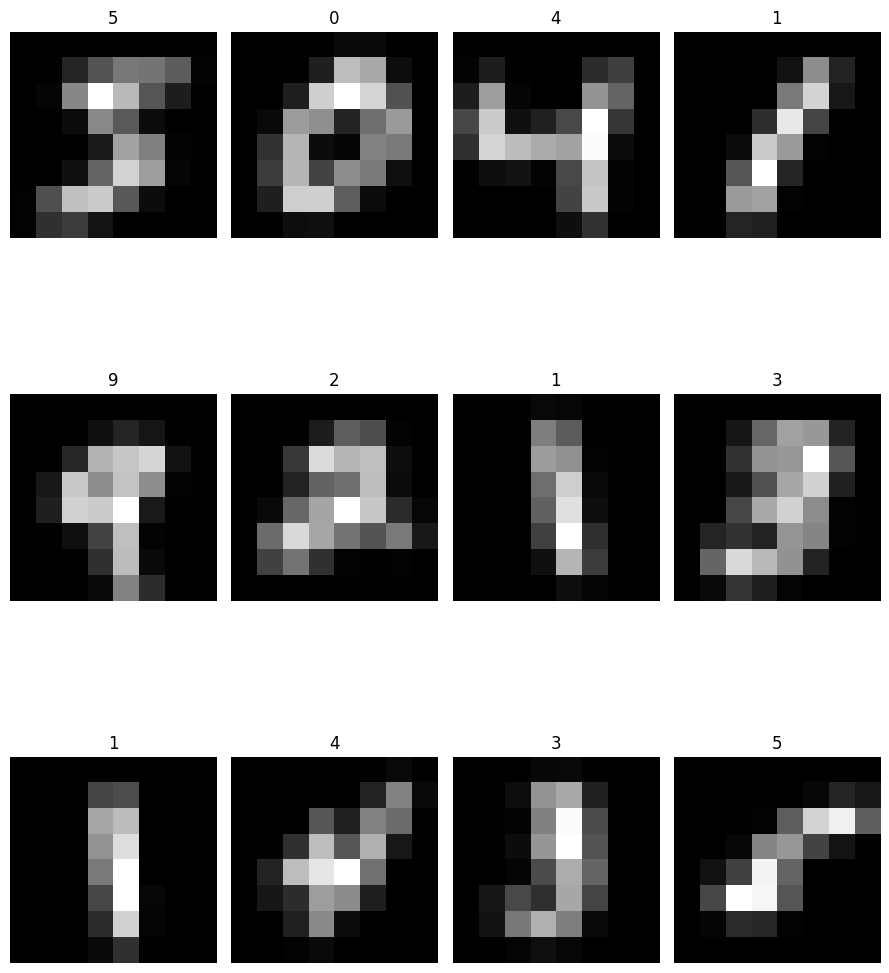

In [10]:
# Assuming each image has shape (C,W,H)=(1, 8, 8)
images, labels = zip(*[train_dataset[i] for i in range(12)])

fig, axes = plt.subplots(3, 4, figsize=(9, 12))
for i, ax in enumerate(axes.flat):
    img = images[i].squeeze(0) # Remove the channel dimension (1,) -> (8, 8)
    ax.imshow(img, cmap='gray')
    ax.set_title(str(labels[i]), fontsize=12)
    ax.axis('off')

plt.tight_layout()
plt.show()

## Step 2: Model development (CNN)

We create a CNN from scratch with `torch.nn.Conv2d` (https://docs.pytorch.org/docs/stable/generated/torch.nn.Conv2d.html). First, we'll define a function with the basic parameters we'll use in each convolution. Each layer receives `ic` channels of input and produces `oc` output channels.

The input of the CNN has shape (N,C,W,H) where N is the batch size, C is the number of input channels, W and H are the width and height of each image. The image size of the input and output of a single convolutional layer are in general different (the output size in this case is half of the input size), but it depends on the parameters of the convolution.

In [11]:
# Convolutional block with batch normalization: ic=input channels; oc=output channels
def conv(ic, oc, act=True):
    ks = 3
    layers = [
        nn.Conv2d(ic, oc, stride=2, kernel_size=ks, padding=ks//2),
        nn.BatchNorm2d(oc)  # insert nn.BatchNorm2d layer after each convolution and before the activation (ReLU).
    ]
    return nn.Sequential(*layers)

# Build the CNN model with layers of conv(ic,oc) and Dropout
ks = 3
simple_cnn = nn.Sequential(
    conv(1, 8),              # convolution and batchnorm; Output: 4x4
    nn.Dropout2d(p=0.25),    # Add 2D Dropout after the first conv layer (common for CNNs)
    nn.ReLU(),               # activation layer
    conv(8, 16),             # Output: 2x2
    nn.Dropout2d(p=0.25),    # Add 2D Dropout after the second conv layer
    nn.ReLU(),               # activation layer
    conv(16, 10, act=False), # Output: 1x1
    nn.Flatten(), # Use the predefined nn.Flatten layer
    # You could also add a standard nn.Dropout here if you had a fully connected layer after Flatten,
    # but in this specific architecture, Flatten is followed directly by the output layer.
)
# Example usage with a dummy input
xb = torch.randn(64, 1, 8, 8)  # (N,C,W,H): batch size 64, 1 channel, 8*8 image
output = simple_cnn(xb)
print(output.shape)  # torch.Size([64, 10])

torch.Size([64, 10])


In [12]:
from torchsummary import summary
# Move the model to the selected device before summarizing
simple_cnn.to(device)
# For your model, input size is (1, 8, 8) (channels, height, width)
summary(simple_cnn, input_size=(1, 8, 8), device=str(device))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1              [-1, 8, 4, 4]              80
       BatchNorm2d-2              [-1, 8, 4, 4]              16
         Dropout2d-3              [-1, 8, 4, 4]               0
              ReLU-4              [-1, 8, 4, 4]               0
            Conv2d-5             [-1, 16, 2, 2]           1,168
       BatchNorm2d-6             [-1, 16, 2, 2]              32
         Dropout2d-7             [-1, 16, 2, 2]               0
              ReLU-8             [-1, 16, 2, 2]               0
            Conv2d-9             [-1, 10, 1, 1]           1,450
      BatchNorm2d-10             [-1, 10, 1, 1]              20
          Flatten-11                   [-1, 10]               0
Total params: 2,766
Trainable params: 2,766
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/back

## Step 3: Model training (and saving `model.state_dict`)

This function `compute_accuracy` is not necessary for training. It will be used to keep track of the accuracy for each batch of examples and used to estimate accuracy after each epoch, both for training and for validation data sets.

In [13]:
# Computes the accuracy for a batch: outputs are probability-like values
def compute_accuracy(outputs, labels):
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == labels).sum().item()
    total = len(labels)
    return correct / total

### Training

This is the main train look in PyTorch. Note that a few extra functionalities were added to keep track of estimated accuracies.

A the end of each epoch, the model is saved into a file. In general, this is not done for large models but it allow us to re-use later each trained model for any epoch.

In [14]:
num_epochs=6
model = simple_cnn

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

model.to(device) #<<<<<<<<<< move model to device

# History object to keep track of accuracy along epochs
history = {'epoch': [], 'train_accuracy': [], 'val_accuracy': []}

for epoch in range(num_epochs):
    print(f'epoch: {epoch+1}; time: {round(time.time())}')
    model.train()
    batch_accuracies=[] # to store estimated accuracy for each batch
    # loop through batches of examples
    for images, labels in train_loader:
        images = images.to(device)  #<<<<<<<<<< move data to device
        labels = labels.to(device)  #<<<<<<<<<< move data to device
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # compute accuracy over the batch
        batch_accuracies.append(compute_accuracy(outputs, labels))
    history['epoch'].append(epoch+1)
    history['train_accuracy'].append(sum(batch_accuracies) / len(batch_accuracies))
    print(f'epoch: {epoch+1}; accuracy: {sum(batch_accuracies) / len(batch_accuracies)}')
    # save current model before next epoch
    model_filename=f'simple_cnn_weights_epoch_{epoch+1}.pth'
    torch.save(model.state_dict(), model_filename) # only save weights, not the network architecture

epoch: 1; time: 1750191208
epoch: 1; accuracy: 0.7095882196162047
epoch: 2; time: 1750191219
epoch: 2; accuracy: 0.8186633795309168
epoch: 3; time: 1750191230
epoch: 3; accuracy: 0.8381030117270789
epoch: 4; time: 1750191241
epoch: 4; accuracy: 0.8480643656716418
epoch: 5; time: 1750191251
epoch: 5; accuracy: 0.8529950692963753
epoch: 6; time: 1750191261
epoch: 6; accuracy: 0.8541944296375267


## Step 4: Validation (and loading model's weights with `load_state_dict`)

Validation is important for several goals, including:
- to estimate the accuracy of the model for the task at hand;
- to determine the optimal number of iterations (epochs);
- to be able to tune the model choosing the best hyperparameters.

Below, we will concentrate on the first two of those issues, and we will compare the estimated overall accuracy over the train and the test sets. In order to do this need to keep track of the intermediate results for each epoch and each batch of examples.

### Loading model weights with `load_state_dict` and compute predictions for the validation data set



In [16]:
for epoch in range(num_epochs):
    print(f'epoch: {epoch+1}; time: {round(time.time())}')
    # Re-instantiate the model architecture before loading state_dict
    model = simple_cnn
    model.to(device) #<<<<<<<<<< move untrained model to device
    model_filename=f'simple_cnn_weights_epoch_{epoch+1}.pth'
    # It's important to load the state_dict onto the device the model is on
    state_dict=torch.load(model_filename, map_location=device) # load trained weights from file
    model.load_state_dict(state_dict)
    # Validation phase
    model.eval()
    batch_accuracies=[]
    with torch.no_grad():
        # loop through batches of examples
        for images, labels in test_loader:
            images = images.to(device)  #<<<<<<<<<< move data to device
            labels = labels.to(device)  #<<<<<<<<<< move data to device
            outputs = model(images)
            # compute accuracy over the batch
            batch_accuracies.append(compute_accuracy(outputs, labels))
        history['val_accuracy'].append(sum(batch_accuracies) / len(batch_accuracies))
        print(f'epoch: {epoch+1}; accuracy: {sum(batch_accuracies) / len(batch_accuracies)}')


epoch: 1; time: 1750191390
epoch: 1; accuracy: 0.8973925159235668
epoch: 2; time: 1750191392
epoch: 2; accuracy: 0.9205812101910829
epoch: 3; time: 1750191393
epoch: 3; accuracy: 0.9272492038216561
epoch: 4; time: 1750191394
epoch: 4; accuracy: 0.931827229299363
epoch: 5; time: 1750191396
epoch: 5; accuracy: 0.9351114649681529
epoch: 6; time: 1750191397
epoch: 6; accuracy: 0.9371019108280255


### Plot training and validation estimated accuracies

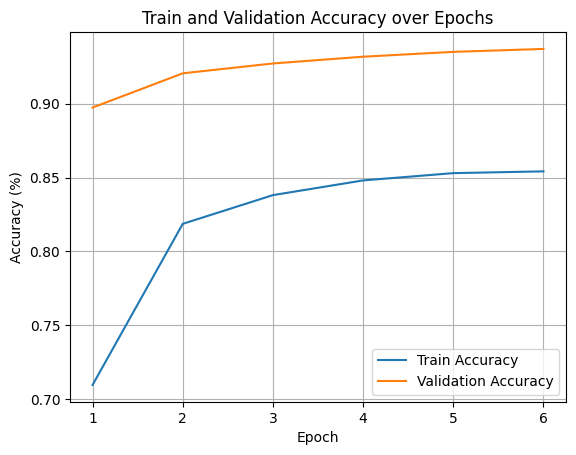

In [17]:
# accuracy plot
plt.plot(history['epoch'], history['train_accuracy'], label='Train Accuracy')
plt.plot(history['epoch'], history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Train and Validation Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
torch.save(model.state_dict(), "simple_cnn.pth")

Write .py file for model

In [25]:
model_code = '''
import torch.nn as nn

def conv(ic, oc, act=True):
    ks = 3
    layers = [
        nn.Conv2d(ic, oc, stride=2, kernel_size=ks, padding=ks // 2),
        nn.BatchNorm2d(oc)
    ]
    return nn.Sequential(*layers)

def get_model():
    model = nn.Sequential(
        conv(1, 8),
        nn.Dropout2d(0.25),
        nn.ReLU(),

        conv(8, 16),
        nn.Dropout2d(0.25),
        nn.ReLU(),

        conv(16, 10, act=False),
        nn.Flatten()
    )
    return model
'''

# Write the string to a file called model.py
with open("model.py", "w") as f:
    f.write(model_code)

Write .py file for app

In [26]:
app_code = '''
import gradio as gr
import torch
from torchvision import transforms
from PIL import Image
from model import get_model

model = get_model()
model.load_state_dict(torch.load("simple_cnn.pth", map_location="cpu"))
model.eval()

transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((8, 8)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

def predict(img):
    img = transform(img).unsqueeze(0)
    with torch.no_grad():
        output = model(img)
        pred = output.argmax(1).item()
    return f"Predicted digit: {pred}"

gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil", tool="editor", label="Draw or Upload a Digit"),
    outputs="text",
    title="Digit Classifier"
).launch()
'''
with open("app.py", "w") as f:
    f.write(app_code)

Write requirements .txt

In [27]:
with open("requirements.txt", "w") as f:
    f.write("torch\ntorchvision\ngradio\nPillow\n")

Zip everything for hugging face

In [28]:
import zipfile

with zipfile.ZipFile("hf_app.zip", "w") as zipf:
    zipf.write("app.py")
    zipf.write("model.py")
    zipf.write("simple_cnn.pth")
    zipf.write("requirements.txt")